In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1> 실버타운 입지조건 분석 프로젝트 - [위치정보 분석] </h1>

- 데이터 개수
  - 실버타운 : 269개
  - 편의시설 : 157,049개
  - 의료시설 : 77,444개

- 편의시설과 의료시설을 하나의 데이터 프레임으로 합치기
  - 시설분류코드 칼럼명 추가
    - 편의시설 : C
    - 의료시설 : M
  - '시설명' 칼럼명 통일하기
    - 편의시설 : 분류명 + 지점명
    - 의료시설 : 요양기관명
- 각 행별 고유 아이디 부여하기 : 실버타운아이디 / 시설아이디
- 위도 경도 값을 이용하여 거리 계산
  - 해버사인(Haversine) 공식 사용
  - 반경 1km 내에 (편의/의료)시설 데이터 필터링하기
  - 결과값으로 새로운 데이터 프레임 만들기
     - 칼럼구성 : 실버타운아이디, 실버타운명, 시설아이디, 시설명, 시설분류코드, 거리
-

In [ ]:
import pandas as pd

silver_town = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/전처리 이후 데이터/SilverTownProcessedData.csv')
convenient_facilities = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/전처리 이후 데이터/ConvenientFacilitiesProcessedData.csv')
medical_facilities = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/전처리 이후 데이터/MedicalFacilitiesProcessedData.csv')

In [ ]:
# 실버타운 아이디 부여

silver_town['실버타운아이디'] = range(1, len(silver_town) + 1)
silver_town

,시설명,시설유형,주소,경도,위도,실버타운아이디
0,청담실버타운5차,주택,서울특별시 강남구 청담동 13-41,127.045851,37.522260,1
1,신우실버타운,주택,서울특별시 강남구 삼성동 65-6,127.051894,37.517074,2
2,호세실버타운,노인복지,인천광역시 강화군 불은면 두운리 342-5,126.477926,37.675357,3
3,치악산실버타운,노인복지,강원특별자치도 횡성군 강림면 강림리 744-5,128.120994,37.357565,4
4,실버타운,노인복지,서울특별시 마포구 창전동 158-1,126.931016,37.545696,5
...,...,...,...,...,...,...
264,주안 에쉐르카운티,노인복지,인천광역시 미추홀구 주안동 1216-17,126.682657,37.445068,265
265,아산실버요양원,"요양원,요양센터",경상북도 경산시 진량읍 마곡리 165-1,128.846678,35.846351,266
266,민들레실버요양원,"요양원,요양센터",경상북도 영천시 화산면 대안리 204-2,128.827800,36.030962,267
267,백세만세실버케어,"요양원,요양센터",충청남도 보령시 청라면 장현리 570-1,126.673640,36.422286,268


In [ ]:
# '시설분류코드' 칼럼 추가
convenient_facilities['시설분류코드'] = 'C'
medical_facilities['시설분류코드'] = 'M'

# 편의시설 : 분류명+지점명→시설명 / 의료시설 : 요양기관명→시설명
convenient_facilities['시설명'] = convenient_facilities.apply(lambda row: f"{row['분류명']} {row['지점명']}", axis=1)
convenient_facilities = convenient_facilities.drop(columns=['분류명', '지점명'])
medical_facilities.rename(columns={'요양기관명':'시설명'}, inplace=True)

# 두 데이터프레임 합치기
facilities = pd.concat([convenient_facilities, medical_facilities], ignore_index=True)

# 시설 아이디 부여
facilities['시설아이디'] = range(1, len(facilities) + 1)

facilities

,분류아이디,분류코드,지번고유코드,경도,위도,주소,시설분류코드,시설명,종별코드명,우편번호,총의사수,시설아이디
0,KCDLCPO23N000070382,90702.0,4.146310e+18,127.108874,37.274116,경기도 용인시 기흥구 신갈동 신갈로84번길 29,C,GS25 신갈타운점,NaN,NaN,NaN,1
1,KCDLCPO23N000070383,90702.0,4.146310e+18,127.103098,37.274834,경기도 용인시 기흥구 신갈동 신정로41번길 1-1,C,GS25 신갈태광점,NaN,NaN,NaN,2
2,KCDLCPO23N000070384,90702.0,4.115010e+18,127.058630,37.726840,경기도 의정부시 신곡동 회룡로 223,C,GS25 신곡본점,NaN,NaN,NaN,3
3,KCDLCPO23N000070385,90702.0,4.115010e+18,127.055564,37.731400,경기도 의정부시 신곡동 발곡로 5,C,GS25 신곡으뜸점,NaN,NaN,NaN,4
4,KCDLCPO23N000070386,90702.0,4.115010e+18,127.063222,37.735586,경기도 의정부시 신곡동 시민로 256,C,GS25 신곡한일점,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...
234488,NaN,NaN,NaN,NaN,NaN,"충청남도 논산시 중앙로491번길 12, (화지동)",M,힘센한의원,한의원,32950,1.0,234489
234489,NaN,NaN,NaN,126.968167,37.530005,"서울특별시 용산구 한강대로 109, (한강로2가, 용성비즈텔)",M,힘찬세상경희한의원,한의원,04376,1.0,234490
234490,NaN,NaN,NaN,127.434883,36.344682,"대전광역시 동구 계족로368번길 22, (성남동)",M,힘찬한의원,한의원,34590,1.0,234491
234491,NaN,NaN,NaN,128.064558,35.178636,"경상남도 진주시 진양호로 284, 2층 (신안동)",M,힘찬한의원,한의원,52697,1.0,234492


In [ ]:
# subset_silver_town = silver_town.iloc[0:50] #1
# subset_silver_town = silver_town.iloc[50:100] #2
# subset_silver_town = silver_town.iloc[100:150] #3
# subset_silver_town = silver_town.iloc[150:200] #4
# subset_silver_town = silver_town.iloc[200:250] #5
subset_silver_town = silver_town.iloc[250:269] #6
subset_silver_town

,시설명,시설유형,주소,경도,위도,실버타운아이디
250,송산실버빌,"요양원,요양센터",광주광역시 광산구 송산동 1235-2,126.715164,35.160455,251
251,가나의작은행복,노인복지,충청북도 음성군 원남면 하노리 124-1,127.697543,36.900804,252
252,다사재가노인복지센터,노인복지,경상북도 영천시 화남면 죽곡리 192,128.958035,36.066667,253
253,동행 위드유 주간보호센터,노인복지,경상북도 문경시 점촌동 462-3,128.194136,36.595569,254
254,정원속궁전,노인복지,경기도 성남시 분당구 정자동 209,127.116998,37.357673,255
255,하랑실버빌리지,"요양원,요양센터",경기도 부천시 원미구 춘의동 205-17,126.786993,37.499407,256
256,파라다이스실버케어,"요양원,요양센터",경기도 남양주시 진접읍 장현리 576-23,127.175374,37.717827,257
257,서울시니어스타워 가양본부,노인복지,서울특별시 강서구 등촌동 637,126.859251,37.556880,258
258,다올재활실버케어,"요양원,요양센터",경기도 포천시 소흘읍 이동교리 733-42,127.118712,37.779219,259
259,데이브실버케어,"요양원,요양센터",경기도 고양시 덕양구 벽제동 518-7,126.906970,37.725069,260


In [ ]:
import math

# 위도 경도 값으로 구하는 두 지점 간의 거리 계산
def haversine(lon1, lat1, lon2, lat2):

    # decimal degrees를 radians로 변환
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine 공식
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # 지구의 평균 반지름 (단위: km)
    return c * r

In [ ]:
def main():

  distance_result = []

  for index, town in subset_silver_town.iterrows():
    print(index, ":", town['시설명'])
    for _, facility in facilities.iterrows():
      distance = haversine(pd.to_numeric(town['경도']), pd.to_numeric(town['위도']), pd.to_numeric(facility['경도']), pd.to_numeric(facility['위도']))
      result_data = {
            '실버타운아이디': town['실버타운아이디'],
            '실버타운명': town['시설명'],
            '실버타운 위도': town['위도'],
            '실버타운 경도': town['경도'],
            '시설아이디': facility['시설아이디'],
            '시설명': facility['시설명'],
            '시설 위도': facility['위도'],
            '시설 경도': facility['경도'],
            '시설분류코드' : facility['시설분류코드'],
            '거리': distance
          }
      distance_result.append(result_data)

  return distance_result

In [ ]:
if __name__ == '__main__':
  distance_df = main()
  distance_df = pd.DataFrame(distance_df)
  distance_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/거리 계산 결과 데이터/DistanceData_n_subset6.csv', index=False)

250 : 송산실버빌
251 : 가나의작은행복
252 : 다사재가노인복지센터
253 : 동행 위드유 주간보호센터
254 : 정원속궁전
255 : 하랑실버빌리지
256 : 파라다이스실버케어
257 : 서울시니어스타워 가양본부
258 : 다올재활실버케어
259 : 데이브실버케어
260 : 연세숲속주간보호
261 : 덕인러브힐
262 : 계양데이케어센터
263 : 희망세상
264 : 주안 에쉐르카운티
265 : 아산실버요양원
266 : 민들레실버요양원
267 : 백세만세실버케어
268 : 푸른마을


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/거리 계산 결과 데이터/DistanceData_n_subset6.csv')
df

,실버타운아이디,실버타운명,실버타운 위도,실버타운 경도,시설아이디,시설명,시설 위도,시설 경도,시설분류코드,거리
0,251,송산실버빌,35.160455,126.715164,1,GS25 신갈타운점,37.274116,127.108874,C,237.666687
1,251,송산실버빌,35.160455,126.715164,2,GS25 신갈태광점,37.274834,127.103098,C,237.669238
2,251,송산실버빌,35.160455,126.715164,3,GS25 신곡본점,37.726840,127.058630,C,287.017344
3,251,송산실버빌,35.160455,126.715164,4,GS25 신곡으뜸점,37.731400,127.055564,C,287.492224
4,251,송산실버빌,35.160455,126.715164,5,GS25 신곡한일점,37.735586,127.063222,C,288.028195
...,...,...,...,...,...,...,...,...,...,...
4455362,269,푸른마을,35.540177,126.775585,234489,힘센한의원,NaN,NaN,M,NaN
4455363,269,푸른마을,35.540177,126.775585,234490,힘찬세상경희한의원,37.530005,126.968167,M,221.926579
4455364,269,푸른마을,35.540177,126.775585,234491,힘찬한의원,36.344682,127.434883,M,107.355111
4455365,269,푸른마을,35.540177,126.775585,234492,힘찬한의원,35.178636,128.064558,M,123.607677


In [ ]:
# 전체 정렬 데이터 내보내기
import pandas as pd
import glob

distance_subset_files = glob.glob('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/거리 계산 결과 데이터/DistanceData_n_subset*.csv')
result = []

for file in distance_subset_files:
    df = pd.read_csv(file)
    df_sorted = df.sort_values(by=['실버타운아이디', '거리'])
    result.append(df_sorted)

# 데이터프레임 리스트를 하나의 데이터프레임으로 결합
combined_df = pd.concat(result)

combined_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/거리 계산 결과 데이터/TotalSortedDistanceData.csv', index=False)

In [ ]:
# 거리가 가까운 30개의 데이터씩만 내보내기
import pandas as pd
import glob

distance_subset_files = glob.glob('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/거리 계산 결과 데이터/DistanceData_n_subset*.csv')
result = []

for file in distance_subset_files:

    df = pd.read_csv(file)
    df_sorted = df.sort_values(by=['실버타운아이디', '거리'])

    top_30 = df_sorted.groupby('실버타운아이디').head(30)
    result.append(top_30)

# 데이터프레임 리스트를 하나의 데이터프레임으로 결합
combined_df = pd.concat(result)

combined_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/거리 계산 결과 데이터/Top30DistanceData.csv', index=False)


<h1> 거리 데이터 분석 </h1>

In [ ]:
top30_distance_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/거리 계산 결과 데이터/Top30DistanceData.csv')
top30_distance_df

,실버타운아이디,실버타운명,실버타운 위도,실버타운 경도,시설아이디,시설명,시설 위도,시설 경도,시설분류코드,거리
0,1,청담실버타운5차,37.522260,127.045851,54215,세탁소/빨래방 청담점,37.522156,127.045741,C,0.015099
1,1,청담실버타운5차,37.522260,127.045851,18595,세탁소/빨래방 nan,37.522042,127.045802,C,0.024679
2,1,청담실버타운5차,37.522260,127.045851,88364,이마트24 청담하나점,37.522215,127.046382,C,0.047058
3,1,청담실버타운5차,37.522260,127.045851,67309,세탁소/빨래방 nan,37.522181,127.046877,C,0.090885
4,1,청담실버타운5차,37.522260,127.045851,69320,GS25 청담타운점,37.522609,127.046920,C,0.101925
...,...,...,...,...,...,...,...,...,...,...
8065,250,오로지종합복지원,37.137526,127.260951,11438,세븐일레븐 안성미리내점,37.107399,127.219962,C,4.942518
8066,250,오로지종합복지원,37.137526,127.260951,218453,안성시쌍지보건진료소,37.098255,127.289385,M,5.042231
8067,250,오로지종합복지원,37.137526,127.260951,86299,세븐일레븐 용인화산점,37.145760,127.204817,C,5.059115
8068,250,오로지종합복지원,37.137526,127.260951,58625,화장실 nan,37.118147,127.312787,C,5.075666


<h1> 지리 데이터를 지도에 시각화 </h1>

In [ ]:
!pip install folium
import folium

In [ ]:
mapCB=folium.Map(location=[37.491145,126.9737511], zoom_start=15)

In [ ]:
# 고유한 실버타운 위치를 지도에 추가 (빨간색 마커)
unique_silver_towns = top30_distance_df[['실버타운명', '실버타운 위도', '실버타운 경도']].drop_duplicates()

for idx, row in unique_silver_towns.iterrows():
    folium.Marker(
        location=[row['실버타운 위도'], row['실버타운 경도']],
        popup=row['실버타운명'],
        icon=folium.Icon(color='red',icon='home')
    ).add_to(mapCB)

# 주변 시설 위치를 지도에 추가 (파란색 마커)
for idx, row in top30_distance_df.iterrows():
  if row['시설분류코드'] == 'C':
    folium.Marker(
        location=[row['시설 위도'], row['시설 경도']],
        popup=row['시설명'],
        icon=folium.Icon(color='blue',icon='star')
    ).add_to(mapCB)
  else :
    folium.Marker(
        location=[row['시설 위도'], row['시설 경도']],
        popup=row['시설명'],
        icon=folium.Icon(color='green',icon='star')
    ).add_to(mapCB)

In [ ]:
mapCB

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
mapCB.save('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/map.html')

<h1> 살기 좋은 조건을 기준으로 Classification </h1>

< 조건 >
*   반경 1km 이내에 의료시설이 있는가
*   반경 1km 이내에 다양한 편의시설이 있는가 (5개 이상)

조건에 모두 해당하면 1, 하나라도 해당하지 않으면 0으로 태그

In [ ]:
top30_distance_df

,실버타운아이디,실버타운명,실버타운 위도,실버타운 경도,시설아이디,시설명,시설 위도,시설 경도,시설분류코드,거리
0,1,청담실버타운5차,37.522260,127.045851,54215,세탁소/빨래방 청담점,37.522156,127.045741,C,0.015099
1,1,청담실버타운5차,37.522260,127.045851,18595,세탁소/빨래방 nan,37.522042,127.045802,C,0.024679
2,1,청담실버타운5차,37.522260,127.045851,88364,이마트24 청담하나점,37.522215,127.046382,C,0.047058
3,1,청담실버타운5차,37.522260,127.045851,67309,세탁소/빨래방 nan,37.522181,127.046877,C,0.090885
4,1,청담실버타운5차,37.522260,127.045851,69320,GS25 청담타운점,37.522609,127.046920,C,0.101925
...,...,...,...,...,...,...,...,...,...,...
8065,250,오로지종합복지원,37.137526,127.260951,11438,세븐일레븐 안성미리내점,37.107399,127.219962,C,4.942518
8066,250,오로지종합복지원,37.137526,127.260951,218453,안성시쌍지보건진료소,37.098255,127.289385,M,5.042231
8067,250,오로지종합복지원,37.137526,127.260951,86299,세븐일레븐 용인화산점,37.145760,127.204817,C,5.059115
8068,250,오로지종합복지원,37.137526,127.260951,58625,화장실 nan,37.118147,127.312787,C,5.075666


In [ ]:
# 거리가 1km 이내인 행만 남기기
within_1km = top30_distance_df[top30_distance_df['거리'] <= 1]

within_1km.to_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/within_1km.csv', index=False)
within_1km

,실버타운아이디,실버타운명,실버타운 위도,실버타운 경도,시설아이디,시설명,시설 위도,시설 경도,시설분류코드,거리
0,1,청담실버타운5차,37.522260,127.045851,54215,세탁소/빨래방 청담점,37.522156,127.045741,C,0.015099
1,1,청담실버타운5차,37.522260,127.045851,18595,세탁소/빨래방 nan,37.522042,127.045802,C,0.024679
2,1,청담실버타운5차,37.522260,127.045851,88364,이마트24 청담하나점,37.522215,127.046382,C,0.047058
3,1,청담실버타운5차,37.522260,127.045851,67309,세탁소/빨래방 nan,37.522181,127.046877,C,0.090885
4,1,청담실버타운5차,37.522260,127.045851,69320,GS25 청담타운점,37.522609,127.046920,C,0.101925
...,...,...,...,...,...,...,...,...,...,...
8037,249,사랑나눔주간보호센터 신가점,35.180559,126.835935,177803,소망의원,35.184936,126.834972,M,0.494507
8038,249,사랑나눔주간보호센터 신가점,35.180559,126.835935,165157,나한조이비인후과의원,35.184950,126.837280,M,0.503349
8039,249,사랑나눔주간보호센터 신가점,35.180559,126.835935,191552,최성란산부인과의원,35.184950,126.837280,M,0.503349
8040,250,오로지종합복지원,37.137526,127.260951,159020,대건효도병원,37.137674,127.261466,M,0.048592


In [ ]:
# 시설분류코드가 M인 행을 필터링하여 그룹별 개수 계산
m_counts = within_1km[within_1km['시설분류코드'] == 'M'].groupby('실버타운아이디').size().reset_index(name='M의 개수')

# M이 있는지 여부를 나타내는 열 추가
m_counts['시설분류코드_M_여부'] = m_counts['M의 개수'] > 0

# 실버타운 아이디를 기준으로 원본 데이터프레임과 병합
result_M = within_1km[['실버타운아이디']].drop_duplicates().merge(m_counts, on='실버타운아이디', how='left').fillna({'M의 개수': 0, '시설분류코드_M_여부': False})

result_M

,실버타운아이디,M의 개수,시설분류코드_M_여부
0,1,11.0,True
1,2,14.0,True
2,3,0.0,False
3,4,1.0,True
4,5,11.0,True
...,...,...,...
227,246,5.0,True
228,247,7.0,True
229,248,5.0,True
230,249,10.0,True


In [ ]:
# 시설분류코드가 C인 행을 필터링하여 그룹별 개수 계산
c_counts = within_1km[within_1km['시설분류코드'] == 'C'].groupby('실버타운아이디').size().reset_index(name='C의 개수')

# C(편의시설)이 있는지 여부를 나타내는 열 추가
c_counts['시설분류코드_C_여부'] = c_counts['C의 개수'] > 0

# 실버타운 아이디를 기준으로 원본 데이터프레임과 병합
result_C = within_1km[['실버타운아이디']].drop_duplicates().merge(c_counts, on='실버타운아이디', how='left').fillna({'C의 개수': 0, '시설분류코드_C_여부': False})

result_C

,실버타운아이디,C의 개수,시설분류코드_C_여부
0,1,19.0,True
1,2,16.0,True
2,3,2.0,True
3,4,3.0,True
4,5,19.0,True
...,...,...,...
227,246,25.0,True
228,247,23.0,True
229,248,25.0,True
230,249,20.0,True


In [51]:
# 실버타운아이디와 실버타운명만 남기고 다른 열 삭제
within_1km_silver_town = within_1km[['실버타운아이디', '실버타운명']].drop_duplicates()

# within_1km_silver_town와 result_M 합치기
merged_df = within_1km_silver_town.merge(result_M, on='실버타운아이디', how='left')
merged_df = merged_df.drop(columns=['M의 개수'])

# '적합' 칼럼 생성
merged_df['적합'] = merged_df['시설분류코드_M_여부'].apply(lambda x: 1 if x else 0)
merged_df.rename(columns={'시설분류코드_M_여부': 'M존재여부'}, inplace=True)

# within_1km_silver_town와 result_C 합치기
merged_df = merged_df.merge(result_C, on='실버타운아이디', how='left')
merged_df = merged_df.drop(columns=['시설분류코드_C_여부'])

# result_C['C의 개수'] 가 5 이상이면 적합 true 아니면 false
merged_df['적합'] = merged_df.apply(lambda row: 1 if row['C의 개수'] >= 5 else 0, axis=1)
merged_df = merged_df[['실버타운아이디', '실버타운명', 'M존재여부', 'C의 개수', '적합']]

merged_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Github/Data_Analysis/SilverTown/result_silver_town.csv', index=False)

merged_df

,실버타운아이디,실버타운명,M존재여부,C의 개수,적합
0,1,청담실버타운5차,True,19.0,1
1,2,신우실버타운,True,16.0,1
2,3,호세실버타운,False,2.0,0
3,4,치악산실버타운,True,3.0,0
4,5,실버타운,True,19.0,1
...,...,...,...,...,...
227,246,대구샘노인요양센터,True,25.0,1
228,247,KB골든라이프케어 평창카운티,True,23.0,1
229,248,케어닥 방문요양돌봄센터 노블카운티점,True,25.0,1
230,249,사랑나눔주간보호센터 신가점,True,20.0,1


In [56]:
# 적합 칼럼으로 그룹화하여 각 그룹의 개수 계산
grouped_df = merged_df.groupby('적합').size().reset_index(name='개수')
grouped_df

,적합,개수
0,0,48
1,1,184


In [ ]:
# 적합 그룹
import matplotlib.pyplot as plt

#한글 폰트 설정

import matplotlib.font_manager as fm  # 폰트 관리

!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

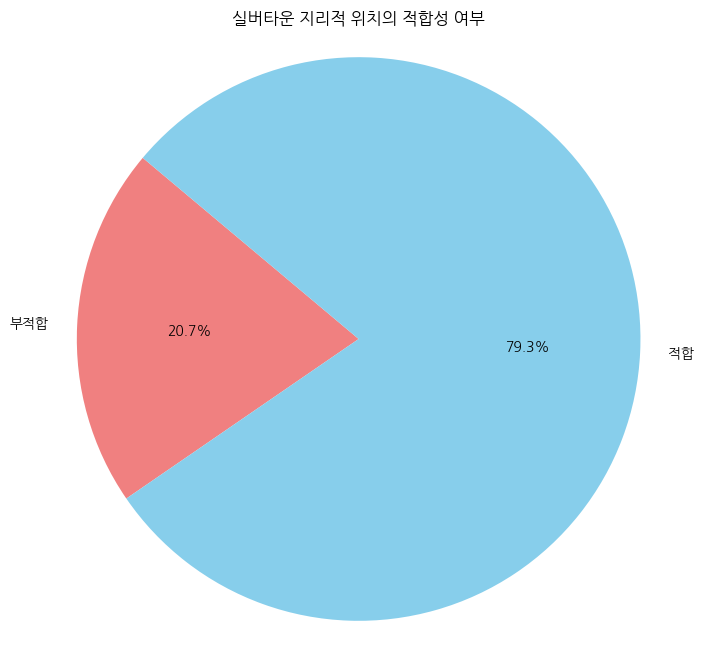

In [68]:
# 적합 칼럼으로 그룹화하여 각 그룹의 개수 계산
grouped_df = merged_df.groupby('적합').size().reset_index(name='개수')

# 라벨링
grouped_df['라벨'] = grouped_df['적합'].map({0: '부적합', 1: '적합'})

# 원 그래프 그리기
plt.figure(figsize=(8, 8))
colors = ['lightcoral', 'skyblue']
plt.pie(grouped_df['개수'], labels=grouped_df['라벨'], colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('실버타운 지리적 위치의 적합성 여부')
plt.axis('equal')  # 파이 그래프를 원형으로 유지

# 그래프 출력
plt.show()

In [61]:
# 부적합 원인 분석

# merged_df에서 '적합'이 0인 행만 남겨서 df 새로 구성
unfit_silver_town = merged_df[merged_df['적합'] == 0]

unfit_grouped_df = unfit_silver_town.groupby('M존재여부').size().reset_index(name='개수')
unfit_grouped_df

,M존재여부,개수
0,False,24
1,True,24


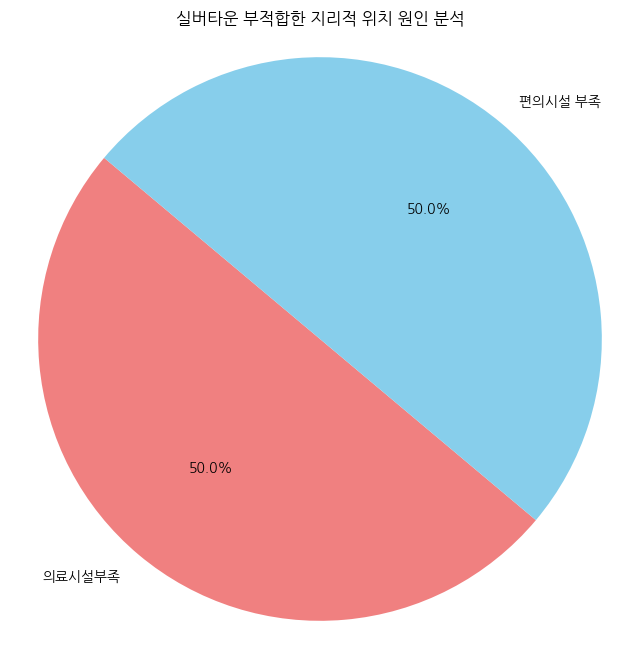

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# 라벨링
unfit_grouped_df['라벨'] = unfit_grouped_df['M존재여부'].map({False: '의료시설부족', True: '편의시설 부족'})

# 파이 그래프 그리기
plt.figure(figsize=(8, 8))
plt.pie(unfit_grouped_df['개수'], labels=unfit_grouped_df['라벨'], autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'skyblue'])
plt.title('실버타운 부적합한 지리적 위치 원인 분석')
plt.axis('equal')  # 파이 그래프를 원형으로 유지

# 그래프 출력
plt.show()
